In [2]:
import torch
from torch.special import bessel_j0
from functools import partial
import warnings
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['font.sans-serif'] = [ 'Arial']

In [4]:
class ScalarSphericalPropagator:
    def __init__(self, n_pix_pupil=223, n_pix_psf=32, img_size=224, D=38, f=50, 
                 wavelength=300, pixel_size=100, refractive_index=1, n_i0=1, 
                 defocus_step=0, n_defocus=1, device='cuda:0'):
        # 存储参数
        self.n_pix_pupil = n_pix_pupil
        self.n_pix_psf = n_pix_psf
        self.D = D
        self.f = f
        self.wavelength = wavelength
        self.pixel_size = pixel_size
        self.refractive_index = refractive_index
        self.n_i0 = n_i0
        self.defocus_step = defocus_step
        self.n_defocus = n_defocus
        self.device = device
        
        # 计算派生参数
        self.na = D / (2 * f)  # 0.38 NA_air
        self.fov = pixel_size * n_pix_psf
        self.k = 2.0 * torch.pi / wavelength
        
        # 计算离焦范围
        self.defocus_min = -defocus_step * n_defocus // 2
        self.defocus_max = defocus_step * n_defocus // 2
        self.defocus_range = torch.linspace(
            self.defocus_min, self.defocus_max, n_defocus
        ).to(device)
        
        # 初始化坐标系统
        self._init_coordinates()
        self._init_pupil_coordinates()
        
        # 预计算defocus filters
        self.defocus_filters = torch.exp(
            1j * self.k * self.defocus_range[:, None] * self.cos_t[None, :] * refractive_index
        ).to(device)
    
    def _init_coordinates(self):
        x = torch.linspace(-self.fov / 2, self.fov / 2, self.n_pix_psf)
        yy, xx = torch.meshgrid(x, x, indexing='ij')
        rr = torch.sqrt(xx**2 + yy**2)
        
        r_unique, rr_indices = torch.unique(rr, return_inverse=True)
        self.rs = r_unique.to(self.device)
        self.rr_indices = rr_indices.to(self.device)
        self.xx, self.yy = xx.to(self.device), yy.to(self.device)
    
    def _init_pupil_coordinates(self):
        s_max = torch.tensor(self.na / self.n_i0)
        theta_max = torch.arcsin(s_max)
        self.thetas = torch.linspace(0, theta_max, self.n_pix_pupil).to(self.device)
        self.dtheta = theta_max / (self.n_pix_pupil - 1)
        
        self.sin_t, self.cos_t = torch.sin(self.thetas), torch.cos(self.thetas)
    
    def get_input_field(self):
        return torch.ones(self.n_pix_pupil, dtype=torch.complex64).to(self.device)
    
    def get_pupil(self):
        return self.get_input_field()
    
    def simpsons_rule(self, fs, dx):
        if fs.shape[0] % 2 == 0:
            warnings.warn("Pupil size is not an odd number! The computed integral will not have high-order accuracy.")
        return (fs[0] + 4 * torch.sum(fs[1:-1:2], dim=0) + 2 * torch.sum(fs[2:-1:2], dim=0) + fs[-1]) * dx / 3.0
    
    def _compute_psf_at_defocus(self, defocus_term, J0, pupil, sin_t):
        integrand = J0 * (pupil * defocus_term * sin_t)[:, None]
        field = self.simpsons_rule(fs=integrand, dx=self.dtheta)
        field = field[self.rr_indices].unsqueeze(0)
        return field / math.sqrt(self.refractive_index)
    
    def compute_focus_field(self):
        bessel_arg = self.k * self.rs[None, :] * self.sin_t[:, None] * self.refractive_index
        J0 = bessel_j0(bessel_arg)
        
        batched_compute = torch.vmap(
            partial(self._compute_psf_at_defocus, J0=J0, pupil=self.get_pupil(), sin_t=self.sin_t),
            in_dims=0
        )
        return batched_compute(self.defocus_filters)

In [5]:
propagator = ScalarSphericalPropagator()
psf = propagator.compute_focus_field()

Text(0.5, 1.0, 'Phase')

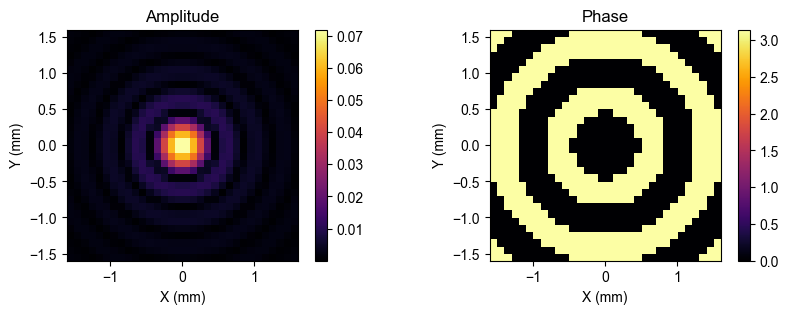

In [6]:
psf_array = psf.squeeze(0).squeeze(0).detach().clone().cpu().numpy()
fig, axes = plt.subplots(1,2,figsize=(10,3))
fov = propagator.fov/1000 #mm
extent = [-fov/2, fov/2, -fov/2, fov/2]
im1 = axes[0].imshow(np.abs(psf_array), cmap='inferno', extent=extent)
axes[0].set_xlabel('X (mm)')
axes[0].set_ylabel('Y (mm)')
plt.colorbar(im1, ax=axes[0])
axes[0].set_title('Amplitude')
im2 = axes[1].imshow(np.angle(psf_array), cmap='inferno', extent=extent)
axes[1].set_xlabel('X (mm)')
axes[1].set_ylabel('Y (mm)')
plt.colorbar(im2, ax=axes[1])
axes[1].set_title('Phase')

In [7]:
plt.savefig('thz_psf_visualization_1THz.png', dpi=300)

<Figure size 640x480 with 0 Axes>